## Anomaly detectoin: expensive restaurants
In sprint 2 we tried this:

**When you get restaurant recommendations as a user you might want a functionality to filter out restaurants on price range. As a restaurant owner you might want to know what other restaurant features influence your price tag. That's why we want to create a classification model that classifies restaurants into cheap, medium of expensive categories.**

At the end of sprint 2 we ended up with our classification model but it was difficult for our model to classify expensive restaurants.


In [1]:
from fastai.imports import *
from sklearn.model_selection import  RandomizedSearchCV
import seaborn as sns

original_df = pd.read_csv("/kaggle/input/tripadvisor/restaurant_listings.csv")
pd.set_option("display.max_columns", None)

in short, we will do the same preprocessing as we did in sprint 1 and the price classification notebook of sprint 2


In [2]:
original_df["rank"]=original_df["rank"].str.replace("#","").astype(float)
original_df["general rating"]=original_df["general rating"].map(lambda x: x.split(" ")[0]).astype(float)
original_df["number of reviews"]=original_df["number of reviews"].map(lambda x: x.split(" ")[0].replace(",","")).astype(float)
original_df['city'] = original_df["address"].str.split(', ').str[-1].str.split(" ").str[0]
first_tag=original_df.tags.str.split("|",expand=True)[0].dropna()
ranges=first_tag[first_tag.str.find("$")!=-1]
original_df["price_tag"]=ranges

*NOTE* we can do this preprocessing on the original df because we are not aggregating data, each row is preprocessed individually (we are not using mean/mode/median/...)

we will use the same preprocessing as we did in sprint 2 for the classification task

In [3]:
original_df.drop(columns=["restaurant name","address","phone number","website url","menu url","timetable","email address","tags","food rating", "service rating","price range","description","dutch description"], inplace=True)

In [4]:
original_df.columns

Index(['rank', 'general rating', 'number of reviews', 'travelers choice',
       'michelin', 'value rating', 'atmosphere rating', 'cuisines',
       'special diets', 'meals', 'restaurant features', 'id', 'city',
       'price_tag'],
      dtype='object')

In [5]:
original_df["price_tag"].value_counts()

$$ - $$$    1540
$            330
$$$$          73
Name: price_tag, dtype: int64

we can see that the expesive restaurants are rare, that's why our classifier from sprint 2 couldn't detect it well, that's why we will try an anomaly detection aproach

missing values

In [6]:
original_df["price_tag"].isna().sum()

638

We have missing data of our price_tag for 638 restaurants, we won't use those restaurants

### our method

Like we said in the end of sprint 2 our approach would be to use the dataset without the expensive restaurants and perform PCA on them, the use the inverse PCA transformation to reconstruct the original data. As an anomaly score, the reconstruction error is used by computing the sum of squared errors (SSE) between the input and output vector. Without removing the components that explain the least variance, this would be a loss-less operation with an SSE equal to zero. However, when the PCA transformation is ftted on only non-expensive restaurants in combination with a reduction in principal components, then the expensive restaurants will yield a higher reconstruction error and thus anomaly score as long as the assumption that expensive restaurants differ from normal restaurants is satisfed.

But because this is sprint 3 we will try the same approach but with an autoencoder

### preprocessing our data

In [7]:
original_df.columns

Index(['rank', 'general rating', 'number of reviews', 'travelers choice',
       'michelin', 'value rating', 'atmosphere rating', 'cuisines',
       'special diets', 'meals', 'restaurant features', 'id', 'city',
       'price_tag'],
      dtype='object')

labeling our columns for easier processing

In [8]:
mutlihot_col = ['cuisines','special diets',"meals","restaurant features"]

In [9]:
#for easier processing later
for col in mutlihot_col:
    original_df[col]=original_df[col].fillna(col+"_missing").str.replace(" ","").str.split(",")

In [10]:
original_df.head(2)

,rank,general rating,number of reviews,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,id,city,price_tag
0,1.0,5.0,922.0,True,False,4.5,-1.0,"[Thai, Healthy]","[VegetarianFriendly, VeganOptions, GlutenFreeOptions]","[Dinner, Drinks]","[Reservations, Seating, ServesAlcohol, FreeWifi, TableService, GiftCardsAvailable]",13969825,Ghent,$$ - $$$
1,1.0,5.0,200.0,False,True,4.5,5.0,"[French, Belgian, European]","[VegetarianFriendly, VeganOptions, GlutenFreeOptions]","[Lunch, Dinner]","[FreeWifi, Reservations, OutdoorSeating, Seating, ParkingAvailable, Freeoff-streetparking, WheelchairAccessible, ServesAlcohol, AcceptsAmericanExpress, AcceptsMastercard, AcceptsVisa, AcceptsCreditCards, TableService, HighchairsAvailable, FullBar]",740727,Ninove,$$$$


### splitting the data

We will train our model only on the cheap and midrange restaurants. But we actually want to build and test 2 systems. 

On the one hand we have the auto encoder, we will train it on only cheap and midrange restaurants and to evaluate it we will use an unseen testset of cheap and midrange restaurants. This testset will be used to determine if our autoencoder actually works. 

On the other hand, we will use the auto encoder in a next step to build a threshold algorithm that can distinguish between cheap and expensive restaurants. Here we will again need a test set that contains both the cheap and the expensive restaurants. In this case  we will use the same cheap restaurants in the test set of the auto encoder as in the test set of the threshold algorithm.

In [11]:

expensive_restaurants = original_df.loc[original_df["price_tag"] == "$$$$" ]
df_train=original_df.drop(expensive_restaurants.index)
df_train=df_train[df_train["price_tag"].isna()==False]

In [12]:
x_train=df_train.sample(frac=0.8,replace=False,random_state=42)
df_test=df_train.drop(index=x_train.index)
df_train=x_train

### defining transformations

In sprint 1 sprint 2 we already did a thorough analyis of the different eatures, their distrubitions, handling outliers ,...
Now we will use a pipeline with column transformers for cleaner code. If there is any misunderstanding or confusion about some transformations/preprocessing steps we did, we want to kindy refer to our sprint 2 regression notebook where we did all of this step by step and explained our intentions.

We got some inspiration from [this blogpost](https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a#:~:text=They%20can%20be%20nested%20and,(model)%20at%20the%20end.) to make this pipeline

ColumnTransformers are built similarly to Pipelines, except you include a third value in each tuple representing the columns to be transformed in that step.

In [13]:
def transform_df(df):
    df["rank_missing"]=0
    df["atmosphere_missing"]=0
    df["value_rating_missing"]=0
    df["general_rating_missing"]=0
    df["atmosphere rating"]=df["atmosphere rating"].replace(-1,np.nan)
    df["value rating"]=df["value rating"].replace(-1,np.nan)
    df["general rating"]=df["general rating"].replace(-1,np.nan)
    df.loc[df["rank"].isna(),"rank_missing"] = 1
    df.loc[df["atmosphere rating"].isna(),"atmosphere_missing"] = 1
    df.loc[df["value rating"].isna(),"value_rating_missing"] = 1
    df.loc[df["general rating"].isna(),"general_rating_missing"] = 1
    df["lg_rank"]=np.log(df["rank"])
    df["lg_reviews"]=np.log(df["number of reviews"]+1)
    df.drop(columns=["rank","number of reviews","id"],inplace=True)
    fea_df, gt_df= df.loc[:, df.columns != 'price_tag'],df["price_tag"]
    return fea_df,gt_df

In [14]:
numeric=["lg_rank","lg_reviews","general rating","value rating","atmosphere rating"] #imputing and scaling
mutlihot_col = ['cuisines','special diets',"meals","restaurant features"]
cat_cols = ['travelers choice', 'michelin',"city",'rank_missing',
       'atmosphere_missing', 'value_rating_missing', 'general_rating_missing']#one hot encoding
label="price_tag"

There is a problem with using multilabelbiniser on multiple columns at once, that's why we used a custom class, the MultiHotEncoder, that wraps around sklearns MultiLabelBinarizer class and provides us with the functionality to use it in a column transformer

thank you stackoverflow 🙏 [this question](https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer)

In [16]:
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer

# from help_script import MultiHotEncoder

pipe=Pipeline([
    ('imputer',SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scale',StandardScaler())
])

cols_trans = ColumnTransformer([
    ('mhe',MultiHotEncoder(),mutlihot_col),
#     ('ohe', OneHotEncoder(drop='first',handle_unknown="infrequent_if_exist"), cat_cols), 
    ('ohe', OneHotEncoder(drop='first',handle_unknown="ignore"), cat_cols), 
    ('impute_and_scale',pipe,numeric)
    ])

### preparing our data

In [17]:
from sklearn.model_selection import train_test_split
##train and validation data
df_train,y_train = transform_df(df_train)
data=cols_trans.fit_transform(df_train)
X_train, X_valid=train_test_split(data, test_size=0.2, random_state=42)

##test data
df_test,y_test = transform_df(df_test)
X_test=cols_trans.transform(df_test)

##expensive restaurants
df_expensive,y_expensive = transform_df(expensive_restaurants)
X_expensive=cols_trans.transform(df_expensive)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) ['EasternEuropean', 'Ethiopian'] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [18]:
X_expensive.shape, X_train.shape, X_valid.shape, X_test.shape

((73, 297), (1196, 297), (300, 297), (374, 297))

### Visualising clusters with t-SNE
before actually building our model we wanted to see of this task was actually possible at all, thats when browsing through the sklearn documentation we came across this beatuiful method (¬‿¬)

*t-Distributed Stochastic Neighbor Embedding (t-SNE)*

From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html): <br>
> t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In plain English, most certainly oversimplifying matters: **t-SNE is a dimensionality reduction technique used for visualisations** of complex datasets.
It **maps clusters in high-dimensional data** to **a two- or three dimensional plane** so we can get an idea of how easy it will be to **discriminate between classes**.
It does this by trying to keep the distance between data points in lower dimensions proportional to the probability that these data points are neighbours in the higher dimensions.

we're going to visualise our training set with our expensive set

In [19]:
features=np.concatenate([X_expensive,X_train])
labels=np.concatenate([np.ones((73,)),np.zeros((1196,))]) ##our labels will be 1 for expensive and 0 for not expensive

In [20]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=42).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')
  # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='expensive'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='cheap'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


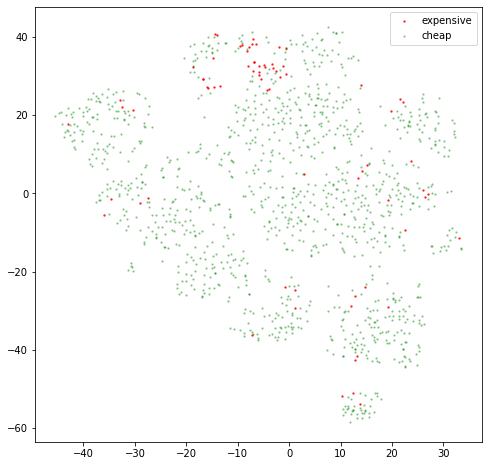

In [21]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')


We can already see that there is a big cluster at the top of the image,however sime expensive restaurants are very much randomly spread out. So we can already see that this will be a difficult task and choosing a threshold with whick we can separate the 2 classes without overlap will be difficult.

**Note: if you have enough imagination (like me) you can see the shape of belgium in the plot above ;)**

## building our autoencoder
with inspiration from [official kaggle blogpost](https://blog.keras.io/building-autoencoders-in-keras.html)

Before we build our autoencoder we have to understand our data. Our input is scaled and some columns are multi-hot encoded as a loss function we will choose mse

<AxesSubplot:>

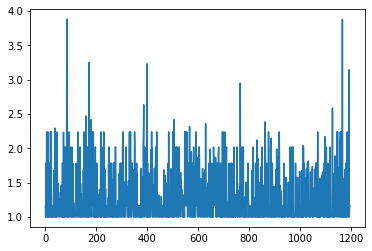

In [22]:
pd.DataFrame(X_train).max(axis=1).plot()

<AxesSubplot:>

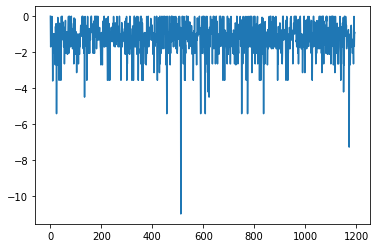

In [23]:
pd.DataFrame(X_train).min(axis=1).plot()

In [24]:
X_train.shape

(1196, 297)

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers


autoencoder = keras.models.Sequential([
    
    # deconstruct / encode
    keras.layers.InputLayer(input_shape=297),
    keras.layers.Dense(264, activation='elu'),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dense(104, activation='elu'),    
    # reconstruction / decode
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dense(264, activation='elu'),
#     tf.keras.layers.Dense(297, activation='elu'),    
    keras.layers.Dense(297)  
])
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 264)               78672     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               33920     
_________________________________________________________________
dense_2 (Dense)              (None, 104)               13416     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               13440     
_________________________________________________________________
dense_4 (Dense)              (None, 264)               34056     
_________________________________________________________________
dense_5 (Dense)              (None, 297)               78705     
Total params: 252,209
Trainable params: 252,209
Non-trainable params: 0
__________________________________________________

2022-12-21 19:14:18.574998: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### callbacks

In [26]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=23,
    min_delta=0.00001,
    restore_best_weights=True,
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,                                     
    patience=3,                                   
    min_delta=0.0001,
    cooldown=0,                               
    verbose=1
) 


In [27]:
history = autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping,plateau],
    validation_data=(X_valid, X_valid)
)

2022-12-21 19:14:18.891326: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
38/38 [==============================] - 1s 11ms/step - loss: 0.0335 - acc: 0.1990 - val_loss: 0.0182 - val_acc: 0.4367
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0153 - acc: 0.4365 - val_loss: 0.0129 - val_acc: 0.4800
Epoch 3/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0113 - acc: 0.4783 - val_loss: 0.0103 - val_acc: 0.5267
Epoch 4/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0091 - acc: 0.4992 - val_loss: 0.0087 - val_acc: 0.5167
Epoch 5/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0077 - acc: 0.5125 - val_loss: 0.0077 - val_acc: 0.5400
Epoch 6/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0068 - acc: 0.5008 - val_loss: 0.0069 - val_acc: 0.5167
Epoch 7/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0061 - acc: 0.5151 - val_loss: 0.0063 - val_acc: 0.4933
Epoch 8/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0055 - 

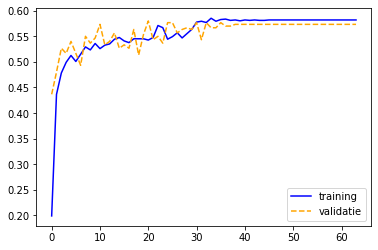

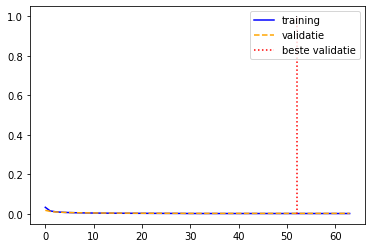

In [28]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['acc']
val_loss_values = history.history['val_acc']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [29]:
loss, acc=autoencoder.evaluate(X_test,X_test)
loss, acc

12/12 [==============================] - 0s 3ms/step - loss: 0.0027 - acc: 0.5053


(0.002655409276485443, 0.5053476095199585)

our model performs slightly worse on the test set than on the training and validation set, but there is no sign of overfitting. Now that we have our autoencoder we can start with our threshold algorithm to detect anomalies

### threshold algorithm to detect anomalies

In [30]:
X_expensive.shape,X_test.shape

((73, 297), (374, 297))

In [31]:
features=np.concatenate([X_expensive,X_test])
labels=np.concatenate([np.ones((73,)),np.zeros((374,))]) #our labels will be 1 for expensive and 0 for not expensive

we will calculate our reconstruction loss and look at the distributions

In [32]:
reconstructions = autoencoder.predict(features)

In [33]:
mse = np.mean(np.power(features - reconstructions, 2), axis=1)

In [34]:
labels.shape,mse.shape

((447,), (447,))

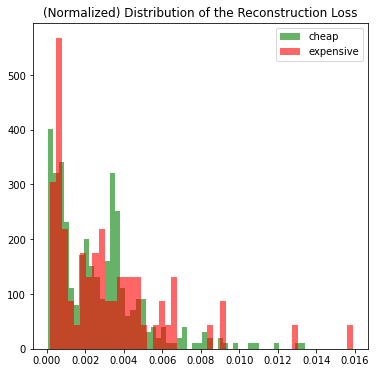

In [35]:
cheap = mse[labels==0]
expensive = mse[labels==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(cheap, bins=50, density=True, label="cheap", alpha=.6, color="green")
ax.hist(expensive, bins=50, density=True, label="expensive", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

this does not look very promising, a lot of expensive restaurants fool the autoencoder. Our autoencoder is not able to distinguish expensive restaurants from cheap ones. By seeing above graph we have come to the conclusion that our initial assumption (that expensive restaurants  differ enough from normal ones) was wrong

But we can still try a different approach, what if we train our autoencoder just for a few epochs, so it barely manages to learn the representation of our cheap restaurants. Maybe then the expensive restaurants will be much more different and we will be able to somewhat separate them.

### training again with fawer epochs

Epoch 1/5
38/38 [==============================] - 1s 10ms/step - loss: 0.0344 - acc: 0.1873 - val_loss: 0.0184 - val_acc: 0.3600
Epoch 2/5
38/38 [==============================] - 0s 6ms/step - loss: 0.0153 - acc: 0.4247 - val_loss: 0.0129 - val_acc: 0.4567
Epoch 3/5
38/38 [==============================] - 0s 6ms/step - loss: 0.0114 - acc: 0.4808 - val_loss: 0.0103 - val_acc: 0.4833
Epoch 4/5
38/38 [==============================] - 0s 6ms/step - loss: 0.0092 - acc: 0.4933 - val_loss: 0.0087 - val_acc: 0.4933
Epoch 5/5
38/38 [==============================] - 0s 6ms/step - loss: 0.0077 - acc: 0.4967 - val_loss: 0.0076 - val_acc: 0.5233


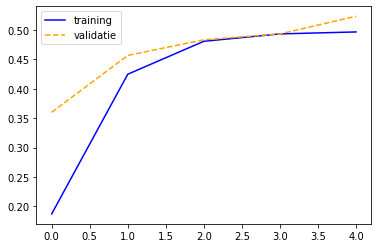

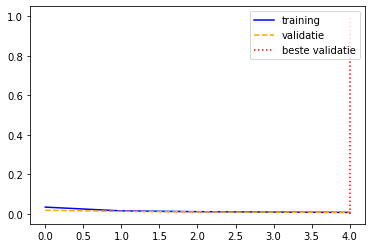

In [36]:

autoencoder = keras.models.Sequential([
    
    # deconstruct / encode
    keras.layers.InputLayer(input_shape=297),
    keras.layers.Dense(264, activation='elu'),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dense(104, activation='elu'),    
    # reconstruction / decode
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dense(264, activation='elu'),
#     tf.keras.layers.Dense(297, activation='elu'),    
    keras.layers.Dense(297)  
])
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])
##training just 5 epochs
history = autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=5,
    batch_size=32,
    validation_data=(X_valid, X_valid)
)
##plotting 
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['acc']
val_loss_values = history.history['val_acc']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

In [37]:
loss, acc=autoencoder.evaluate(X_test,X_test)
loss, acc

12/12 [==============================] - 0s 2ms/step - loss: 0.0077 - acc: 0.4947


(0.007652894128113985, 0.4946524202823639)

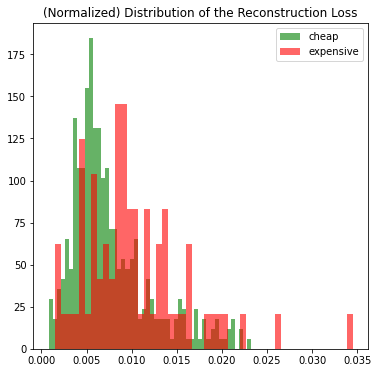

In [38]:
reconstructions = autoencoder.predict(features)
mse = np.mean(np.power(features - reconstructions, 2), axis=1)
cheap = mse[labels==0]
expensive = mse[labels==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(cheap, bins=50, density=True, label="cheap", alpha=.6, color="green")
ax.hist(expensive, bins=50, density=True, label="expensive", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

We can see that on average our mse has increased, which means our autoencoder was performing worse when it comes to reconstruction the data. But that was not really important here. Our goal is not making a good auto encoder. We don't really care if it performs bad, it should just be worse for the expensive restaurants so we can separate them. 

Now it's only a little it better, but just for practice we're going to continue and finish our threshold algorithm

when choosing our threshold we have to think about the fals positives and the false negatives. Our positive class here are the expensive restaurants. When a used wants to filter out the expensive restaurants and only wants to see cheap ones we have to think how bad is it if we miss some and they don't get filtered out? No that bad actually because there are lots of other cheap restaurants the user can still choose. If there is a scenario where the user actually wants to visit a expensive restaurant and the list is contaminated with cheap ones, that would lead to a bad user experience. That's why we choose to prioritize a high precision instead of a high recall.

In [39]:
threshold = 0.023
outlier=mse>threshold
outlier=outlier.astype(int)

In [40]:
def plot_normalised_cm(cm):
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cmn, columns=["cheap","expensive"], index =["cheap","expensive"])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='.2f',
                annot_kws={'size': 10})

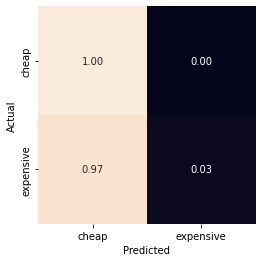

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, outlier)

# true/false positives/negatives
plot_normalised_cm(cm)

with our current threshold, if we predict an expensive restaurant, the chance is actually higher that it will actuallly be an expensive one, just like we wanted. We realise that this model cannot be used in practise because it is unable to discriminate between the expensive and cheap restaurants well enough. But what is more important here is that we kind of experimented, realised that if our model becomes bad at recreating cheap restaurants( which it was trained on) it may be even worse on predicting expensive ones ant that was a (little bit 😉) true